# A first descriptive analysis

One of the best ways to get started with the OULAD analysis might be to explore the
original paper that introduced the OULAD dataset.
{cite}`kuzilek_hlosta_zdrahal_2017`

In this section we try to reproduce and summarize their findings.
We also take some notes at the end which might be used later.

```{bibliography}
:filter: docname in docnames
```

In [1]:
import matplotlib.pyplot as plt
import pandas as pd

from oulad import get_oulad

oulad = get_oulad()

## General statistics

In [2]:
module_count = oulad.courses.code_module.nunique()
print(
    "OULAD contains data about:\n"
    f"  - {oulad.courses.shape[0]} courses from {module_count} modules "
    "(4 STEM modules and 3 Social Sciences modules)\n"
    f"  - {oulad.student_info.shape[0]} students\n"
    f"  - {oulad.student_registration.shape[0]} student registrations\n"
    f"  - {oulad.student_vle.shape[0]} VLE interaction entries"
)

OULAD contains data about:
  - 22 courses from 7 modules (4 STEM modules and 3 Social Sciences modules)
  - 32593 students
  - 32593 student registrations
  - 10655280 VLE interaction entries


### Student registration count by module with domain information

In [3]:
registration_count = (
    oulad.student_registration.groupby(
        ["code_module", "code_presentation"], as_index=False
    )
    .count()
    .groupby(["code_module"])
    .agg(
        presentations=pd.NamedAgg(column="code_presentation", aggfunc="count"),
        students=pd.NamedAgg(column="id_student", aggfunc="sum"),
    )
)
oulad.domains.join(registration_count, on="code_module")

,code_module,domain,presentations,students
0,AAA,Social Sciences,2,748
1,BBB,Social Sciences,4,7909
2,CCC,STEM,2,4434
3,DDD,STEM,4,6272
4,EEE,STEM,3,2934
5,FFF,STEM,4,7762
6,GGG,Social Sciences,3,2534


### Student registration count by module-presentation

In [4]:
registration_count = oulad.student_registration.groupby(
    ["code_module", "code_presentation"]
).size()
registration_count.reset_index()

,code_module,code_presentation,0
0,AAA,2013J,383
1,AAA,2014J,365
2,BBB,2013B,1767
3,BBB,2013J,2237
4,BBB,2014B,1613
5,BBB,2014J,2292
6,CCC,2014B,1936
7,CCC,2014J,2498
8,DDD,2013B,1303
9,DDD,2013J,1938


In [5]:
max_id = registration_count.idxmax()
min_id = registration_count.idxmin()
print(
    f"The largest module-presentation {max_id} contains "
    f"{registration_count[max_id]} student registrations.\n"
    f"The smallest module-presentation {min_id} contains "
    f"{registration_count[min_id]} student registrations. \n"
    f"The average module-presentation registration count is "
    f"{registration_count.mean()}."
)

The largest module-presentation ('CCC', '2014J') contains 2498 student registrations.
The smallest module-presentation ('AAA', '2014J') contains 365 student registrations. 
The average module-presentation registration count is 1481.5.


### Student assessment count

In [6]:
exams = oulad.assessments[oulad.assessments.assessment_type == "Exam"]
print(
    f"The student_assessment table contains {oulad.student_assessment.shape[0]} rows."
    "\n"
    f"The assessment tabel contains {exams.shape[0]} Exams.\n"
    f"{pd.merge(oulad.student_assessment, exams, on='id_assessment').shape[0]} "
    "student_assessments are Exams."
)

The student_assessment table contains 173912 rows.
The assessment tabel contains 24 Exams.
4959 student_assessments are Exams.


### Student info attributes distribution for CCC module

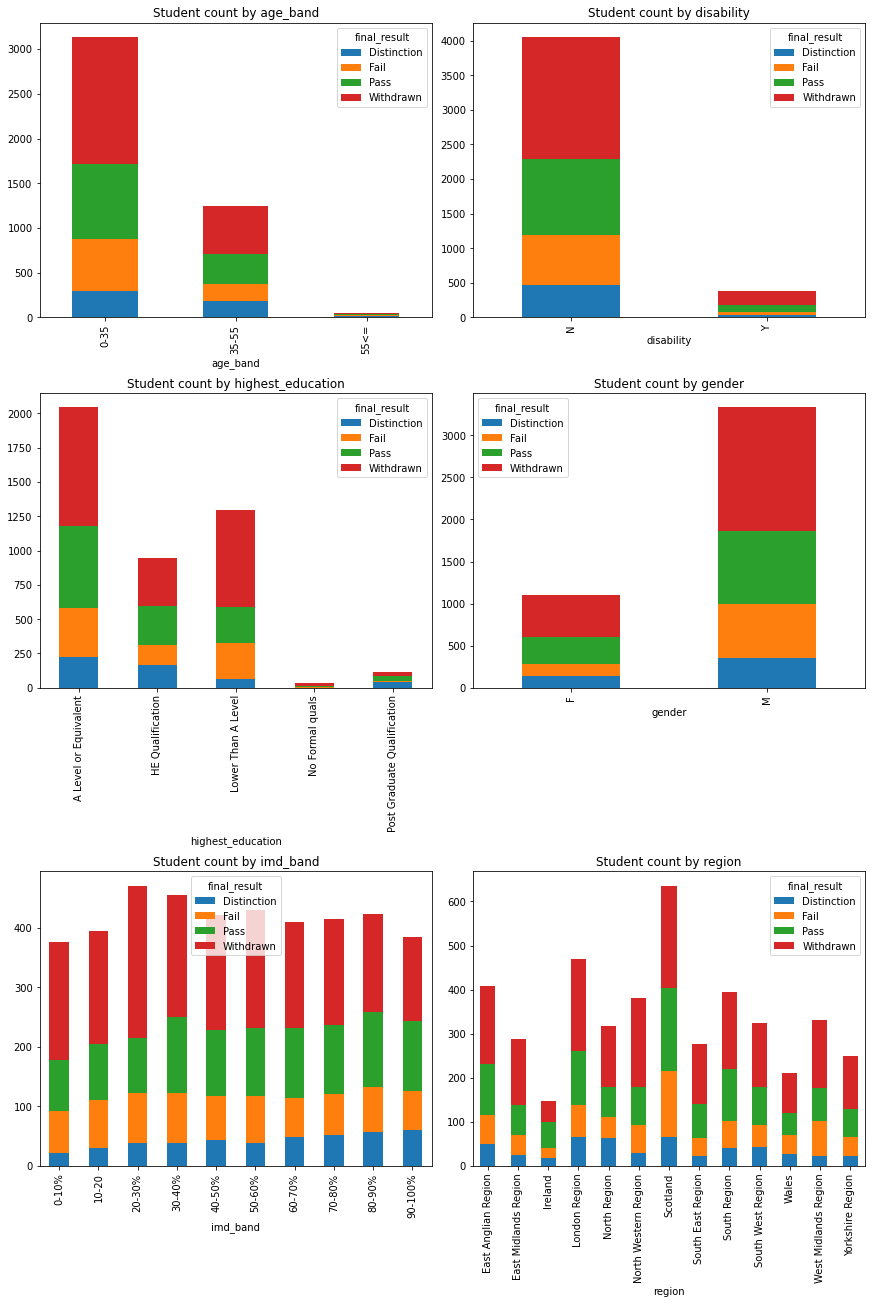

In [7]:
ccc_student_info = oulad.student_info[oulad.student_info.code_module == "CCC"].drop(
    "code_module", axis=1
)

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 18), constrained_layout=True)

ccc_student_info.groupby(["age_band", "final_result"]).size().unstack().plot.bar(
    stacked=True, ax=axes[0, 0], title="Student count by age_band"
)
ccc_student_info.groupby(["disability", "final_result"]).size().unstack().plot.bar(
    stacked=True, ax=axes[0, 1], title="Student count by disability"
)
ccc_student_info.groupby(
    ["highest_education", "final_result"]
).size().unstack().plot.bar(
    stacked=True, ax=axes[1, 0], title="Student count by highest_education"
)
ccc_student_info.groupby(["gender", "final_result"]).size().unstack().plot.bar(
    stacked=True, ax=axes[1, 1], title="Student count by gender"
)
ccc_student_info.groupby(["imd_band", "final_result"]).size().unstack().plot.bar(
    stacked=True, ax=axes[2, 0], title="Student count by imd_band"
)
ccc_student_info.groupby(["region", "final_result"]).size().unstack().plot.bar(
    stacked=True, ax=axes[2, 1], title="Student count by region"
)
plt.show()

## Notes

- The inital total number of students in the selected modules was 38239.
- Students in a module-presentation are organised into study groups of ~20 people.
- Module resources are available from the VLE system a few weeks before the start.
- If the final exam `date` is missing in the `assessments` table, it takes place
  during the last week of the module-presentation.
- The structure of B and J presentations may differ.
- In the `student_registration` table if the `date_unregistration` field is present
  the student has withdrawn.
- If the student does not submit an assessment, no result is recorded.
- Results of the final exam are usually missing.
- An assessmnet score lower than 40 is interpreted as a failure.